In [26]:
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA

from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score

import numpy as np
import matplotlib.pyplot as plt
import os

In [27]:
figdir = "./"
def savefig(fname):
    plt.savefig(os.path.join(figdir, fname))

$$
\mathcal{N}(\mathbf{y}\vert\mathbf{\mu},\mathbf{\Sigma})=\frac{1}{(2\pi)^{D/2}\vert\mathbf{\Sigma}\vert^{1/2}}\exp{\left\{-\frac{1}{2}(\mathbf{y}-\mathbf{\mu})^\intercal(\mathbf{\Sigma})^{-1}(\mathbf{y}-\mathbf{\mu})\right\}}
$$

In [28]:
def mvn2d(x, y, u, sigma):
    xx, yy = np.meshgrid(x, y)
    xy = np.c_[xx.ravel(), yy.ravel()]
    sigma_inv = np.linalg.inv(sigma)
    z = np.dot((xy - u), sigma_inv)
    z = np.sum(z * (xy - u), axis=1) # to avoid memory overflow
    z = np.exp(-0.5 * z)
    z = z / (2 * np.pi * np.linalg.det(sigma) ** 0.5)
    return z.reshape(xx.shape)

## Make data

AB are the last two digits of your student number.
For example, if your student number is 170201003 then AB is 03 (A = 0, B = 3).

If any digit is 0, please add +1. In the example above, A will become 1.

Please fill A and in the code below as follows.

Sigma2 = np.array([[A, 0], [0, B]])

In [29]:
mu1 = [0,0]
Sigma1 = np.array([[4, 2], [1, 7]])

mu2 = [0, 4]
Sigma2 = np.array([[1, 2], [0, 7]])

mu3 = [4, 4]
Sigma3 = np.array([[3, 2], [-3, 7]])

mus = [mu1, mu2, mu3]
sigmas = [Sigma1, Sigma2, Sigma3]

In [30]:
ngrid = 200
np.random.seed(0)

def make_data(mu, sigma, n_samples_per_class = 30, seed = 0):
    np.random.seed(seed)
    x = []
    labels = []
    nclasses = len(mu)
    for i in range(nclasses):
        x.append(np.random.multivariate_normal(mu[i], sigma[i], n_samples_per_class))
        labels.append([i] * n_samples_per_class)
    return x, labels

def make_grid(x):
    #points = np.vstack(x)
    #x_min, y_min = np.min(points, axis=0)
    #x_max, y_max = np.max(points, axis=0)
    #x_range = np.linspace(x_min - 1, x_max + 1, ngrid)
    #y_range = np.linspace(y_min - 1, y_max + 1, ngrid)
    x_range = np.linspace(-5, 10, ngrid)
    y_range = np.linspace(-5, 10, ngrid)
    xx, yy = np.meshgrid(x_range, y_range)
    return xx, yy, x_range, y_range

def plot_dboundaries(xx, yy, z, z_p):
    plt.pcolormesh(xx, yy, z, alpha=0.1)
    plt.jet()
    nclasses = z_p.shape[1]
    for j in range(nclasses):
        plt.contour(xx, yy, z_p[:, j].reshape(ngrid, ngrid), [0.5], colors="k")

def plot_points(x):
    c = "bgr"
    m = "xos"
    for i, point in enumerate(x):
        N = point.shape[0]
        #nplot = min(N, 30)
        nplot = N
        plt.plot(point[:nplot, 0], point[:nplot, 1], c[i] + m[i])

def plot_contours(xx, yy, x_range, y_range, u, sigma):
    nclasses = len(u)
    c = "bgr"
    m = "xos"
    for i in range(nclasses):
        prob = mvn2d(x_range, y_range, u[i], sigma[i])
        cs = plt.contour(xx, yy, prob, colors=c[i])

def make_one_hot(yhat):
    yy = yhat.reshape(-1, 1)
    enc = OneHotEncoder(sparse=False)
    Y = enc.fit_transform(yy)
    return Y

### Making training data

<ipython-input-30-9e95eaca615d>:10: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  x.append(np.random.multivariate_normal(mu[i], sigma[i], n_samples_per_class))


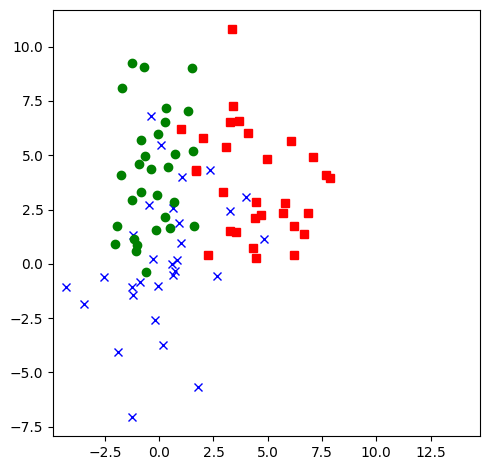

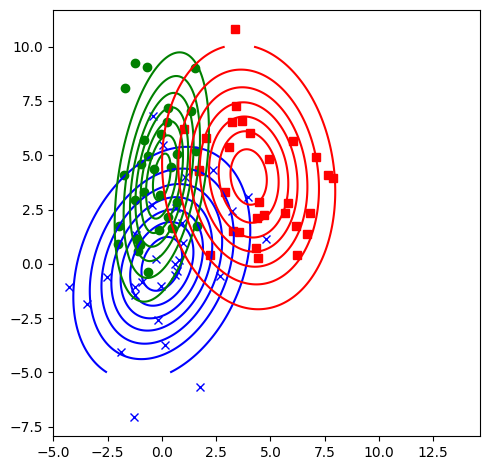

In [42]:
x, labels = make_data(mus, sigmas, n_samples_per_class = 30, seed = 0)
xx, yy, x_range, y_range = make_grid(x)
X = np.vstack(x)
Y = np.hstack(labels)

plt.figure()
plot_points(x)
plt.axis("square")
plt.tight_layout()
savefig("gda_2d_data.pdf")
plt.show()

plt.figure()
plot_points(x)
plot_contours(xx, yy, x_range, y_range, mus, sigmas)
plt.axis("square")
plt.tight_layout()
savefig("gda_2d_contours.pdf")
plt.show()

### Making test data

**Set the random seed for creating test data as AB.**

In [43]:
x_test, labels_test = make_data(mus, sigmas, n_samples_per_class=100, seed=13)
X_test = np.vstack(x_test)
Y_test = np.hstack(labels_test)

<ipython-input-30-9e95eaca615d>:10: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  x.append(np.random.multivariate_normal(mu[i], sigma[i], n_samples_per_class))


## Code for model fitting and plotting

In [44]:
def fit_and_plot(clf, name, mus, sigmas):
    clf.fit(X, Y)

    y_pred = clf.predict(X_test)
    acc = accuracy_score(Y_test, y_pred)
    print("Test accuracy: ", acc)

    z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    z = z.reshape(ngrid, ngrid)
    z_p = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])
    yhat = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Yhat = make_one_hot(yhat)


    plt.figure()
    plot_dboundaries(xx, yy, z, Yhat)
    plot_points(x_test)
    plot_contours(xx, yy, x_range, y_range, mus, sigmas)
    plt.title(name)
    plt.axis("square")
    plt.tight_layout()
    savefig("gda_2d_{}.pdf".format(name))
    plt.show()

## Linear Discriminant Analysis (LDA)

In [45]:
def estimate_mvn_tied(X, Y):
    classes = np.unique(Y)
    nclasses = len(classes)
    Sigma = np.cov(X, rowvar=False) # rowvar=False: each column represents a variable, while the rows contain observations.
    sigmas = [Sigma] * nclasses
    mus = []
    for c in classes:
        ndx = Y == c
        Xc = X[ndx]
        mu_c = np.mean(Xc, axis=0)
        mus.append(mu_c)
    return mus, sigmas

mus_tied, sigmas_tied = estimate_mvn_tied(X, Y)

Test accuracy:  0.7566666666666667


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


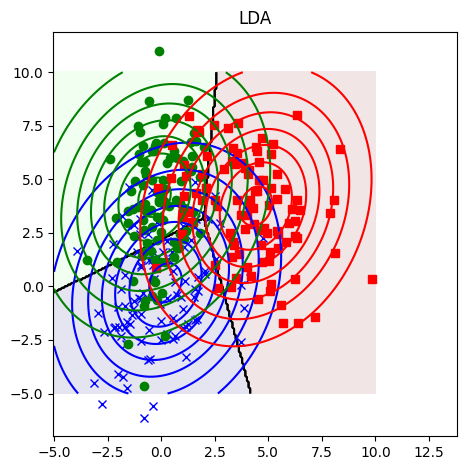

In [46]:
fit_and_plot(LDA(), "LDA", mus_tied, sigmas_tied)

## Gaussian Naive Bayes Classifier

In [48]:
def estimate_mvns_diag(X, Y):
    # Get unique classes
    classes = np.unique(Y)
    mus = []
    sigmas = []

    for c in classes:
        X_c = X[Y == c]
        # Code for estimate the mean vector of each class
        mu_c = np.mean(X_c, axis=0)
        mus.append(mu_c)
        #Code for estimate the covariance matrix of each class (Note: the QDA assumptions)
        var_c = np.var(X_c, axis=0)
        Sigma_c = np.diag(var_c)
        sigmas.append(Sigma_c)

    return mus, sigmas
mus_est_diag, sigmas_est_diag = estimate_mvns_diag(X, Y)


Test accuracy:  0.7666666666666667


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


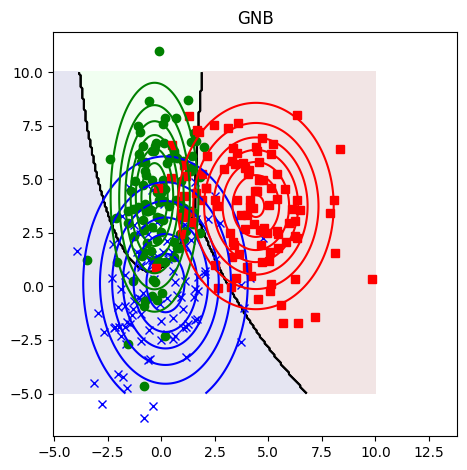

In [49]:
fit_and_plot(GaussianNB(), "GNB", mus_est_diag, sigmas_est_diag)

## Quadratic Discriminant Analysis (QDA)

In [50]:
def estimate_mvns(X, Y):
    classes = np.unique(Y)
    mus = []
    sigmas = []
    for c in classes:
        X_c = X[Y == c]
        ### Code for estimate the mean vector of each class
        mu_c = np.mean(X_c, axis=0)
        ###
        mus.append(mu_c)

        ### Code for estimate the covariance matrix of each class (Note: the QDA assumptions)
        Sigma_c = np.cov(X_c, rowvar=False)
        ####

        sigmas.append(Sigma_c)
    return mus, sigmas

mus_est, sigmas_est = estimate_mvns(X, Y)

Test accuracy:  0.7533333333333333


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


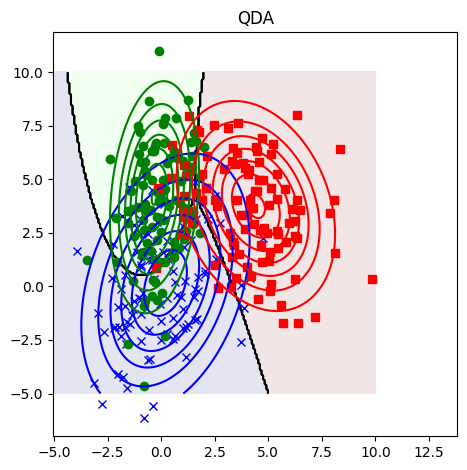

In [51]:
fit_and_plot(QDA(), "QDA", mus_est, sigmas_est)

## Compare Gaussian Naive Bayes, LDA, and QDA.

Comparison of Classifiers
Based on the test accuracy, we can compare the performance of the three classifiers:

*   GNB follows with an accuracy of 0.7667.
*   LDA has the highest accuracy at 0.7567.
*   QDA has the lowest accuracy among the three with 0.7533.

While GNB performs slightly better than the other two classifiers, the differences in accuracy are relatively small. This comparison shows that GNB is the most effective model for this particular dataset, followed closely by LDA and QDA.